# LIBRERIAS

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error, r2_score
import xgboost as xgb
from ydata_profiling import ProfileReport

c:\Users\cecir\.conda\envs\ds_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# ETL

In [41]:
df_modelo = pd.read_csv("accidentes_2016_2023.csv")

C:\Users\cecir\AppData\Local\Temp\ipykernel_16680\2839577596.py:1: DtypeWarning: Columns (48) have mixed types. Specify dtype option on import or set low_memory=False.
  df_modelo = pd.read_csv("accidentes_2016_2023.csv")


In [42]:
df_modelo.duplicated().sum()

10256

In [43]:
df_modelo = df_modelo.drop_duplicates()

In [46]:
df_modelo.info()

<class 'pandas.core.frame.DataFrame'>
Index: 762761 entries, 0 to 773016
Data columns (total 71 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ANYO                      762761 non-null  int64  
 1   MES                       762761 non-null  int64  
 2   DIA_SEMANA                762761 non-null  int64  
 3   HORA                      762761 non-null  int64  
 4   COD_PROVINCIA             762761 non-null  int64  
 5   COD_MUNICIPIO             760553 non-null  float64
 6   ISLA                      46913 non-null   float64
 7   ZONA                      762761 non-null  int64  
 8   ZONA_AGRUPADA             762761 non-null  int64  
 9   CARRETERA                 762760 non-null  object 
 10  KM                        334228 non-null  float64
 11  SENTIDO_1F                762761 non-null  int64  
 12  TITULARIDAD_VIA           762761 non-null  int64  
 13  TIPO_VIA                  762676 non-null  float6

In [47]:
df_modelo.head()

,ANYO,MES,DIA_SEMANA,HORA,COD_PROVINCIA,COD_MUNICIPIO,ISLA,ZONA,ZONA_AGRUPADA,CARRETERA,...,PRIORI_OTRA,CONDICION_NIVEL_CIRCULA,CONDICION_FIRME,CONDICION_ILUMINACION,CONDICION_METEO,CONDICION_NIEBLA,CONDICION_VIENTO,VISIB_RESTRINGIDA_POR,ACERA,TRAZADO_PLANTA
0,2016,3,4,16,1,1059.0,NaN,3,2,No inventariada,...,999,6,9,1,7,NaN,NaN,18,998,998
1,2016,3,4,14,1,1059.0,NaN,3,2,No inventariada,...,999,6,9,1,7,NaN,NaN,18,999,998
2,2016,3,4,7,1,1059.0,NaN,3,2,No inventariada,...,999,6,9,4,7,NaN,NaN,18,998,998
3,2016,3,3,18,1,1059.0,NaN,3,2,No inventariada,...,1,6,9,1,7,NaN,NaN,18,998,998
4,2016,3,2,20,1,1059.0,NaN,3,2,No inventariada,...,1,6,9,4,7,NaN,NaN,18,998,998


In [48]:
df_modelo = df_modelo.copy()  # copia segura

df_modelo['FRANJA_HORARIA'] = pd.cut(
    df_modelo['HORA'],
    bins=[-1, 6, 12, 18, 24],
    labels=['Madrugada', 'Mañana', 'Tarde', 'Noche'],
    right=False
)

df_modelo['FRANJA_HORARIA'] = df_modelo['FRANJA_HORARIA'].astype('category')



In [49]:
df_modelo['DIA_TIPO'] = df_modelo['DIA_SEMANA'].apply(lambda x: 'Fin de Semana' if x in [6, 7] else 'Entre Semana')


In [50]:
columnas_modelo = ["COD_PROVINCIA", "ZONA_AGRUPADA", "DIA_TIPO", "FRANJA_HORARIA", "TOTAL_MU30DF",
                   "TOTAL_HG30DF", "TOTAL_HL30DF", "TOTAL_VICTIMAS_30DF", "TOTAL_VEHICULOS"]
df_modelo = df_modelo[columnas_modelo]


In [51]:
df_modelo.head()

,COD_PROVINCIA,ZONA_AGRUPADA,DIA_TIPO,FRANJA_HORARIA,TOTAL_MU30DF,TOTAL_HG30DF,TOTAL_HL30DF,TOTAL_VICTIMAS_30DF,TOTAL_VEHICULOS
0,1,2,Entre Semana,Tarde,0,0,1,1,1
1,1,2,Entre Semana,Tarde,0,0,1,1,1
2,1,2,Entre Semana,Mañana,0,0,1,1,2
3,1,2,Entre Semana,Noche,0,0,1,1,2
4,1,2,Entre Semana,Noche,0,0,2,2,2


In [52]:
df_modelo.to_csv("df_modelo.csv", index=False)

# EDA

In [53]:
df_modelo.describe(include='all')

,COD_PROVINCIA,ZONA_AGRUPADA,DIA_TIPO,FRANJA_HORARIA,TOTAL_MU30DF,TOTAL_HG30DF,TOTAL_HL30DF,TOTAL_VICTIMAS_30DF,TOTAL_VEHICULOS
count,762761.000000,762761.000000,762761,762761,762761.000000,762761.000000,762761.000000,762761.000000,762761.000000
unique,NaN,NaN,2,4,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,Entre Semana,Tarde,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,575682,293311,NaN,NaN,NaN,NaN,NaN
mean,23.611894,1.637584,NaN,NaN,0.017902,0.090508,1.247931,1.356341,1.746255
std,14.250126,0.480698,NaN,NaN,0.144980,0.324328,0.863511,0.841099,0.742464
min,1.000000,1.000000,NaN,NaN,0.000000,0.000000,0.000000,1.000000,0.000000
25%,8.000000,1.000000,NaN,NaN,0.000000,0.000000,1.000000,1.000000,1.000000
50%,28.000000,2.000000,NaN,NaN,0.000000,0.000000,1.000000,1.000000,2.000000
75%,35.000000,2.000000,NaN,NaN,0.000000,0.000000,1.000000,1.000000,2.000000


In [61]:
profile = ProfileReport(df_modelo, title="EDA de Accidentes", explorative=True)
profile.to_notebook_iframe() 

Render HTML: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


In [62]:
# Definir criterios de análisis
criterios = ['TOTAL_MU30DF', 'TOTAL_HG30DF', 'TOTAL_HL30DF', 'TOTAL_VEHICULOS']


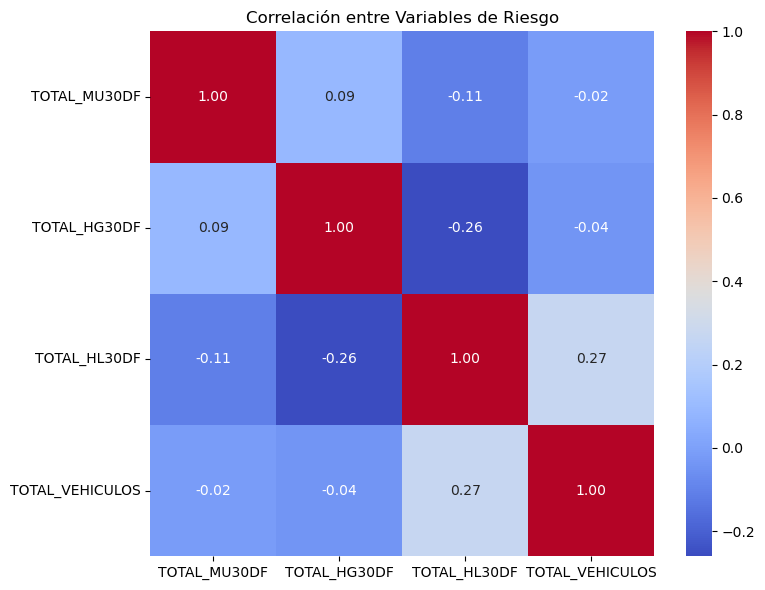

In [63]:
# 1. Heatmap de correlación entre criterios
plt.figure(figsize=(8, 6))
sns.heatmap(df_modelo[criterios].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlación entre Variables de Riesgo")
plt.tight_layout()
plt.show()

C:\Users\cecir\AppData\Local\Temp\ipykernel_16680\4128102811.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_modelo, x='FRANJA_HORARIA', y='TOTAL_VICTIMAS_30DF', palette='pastel')


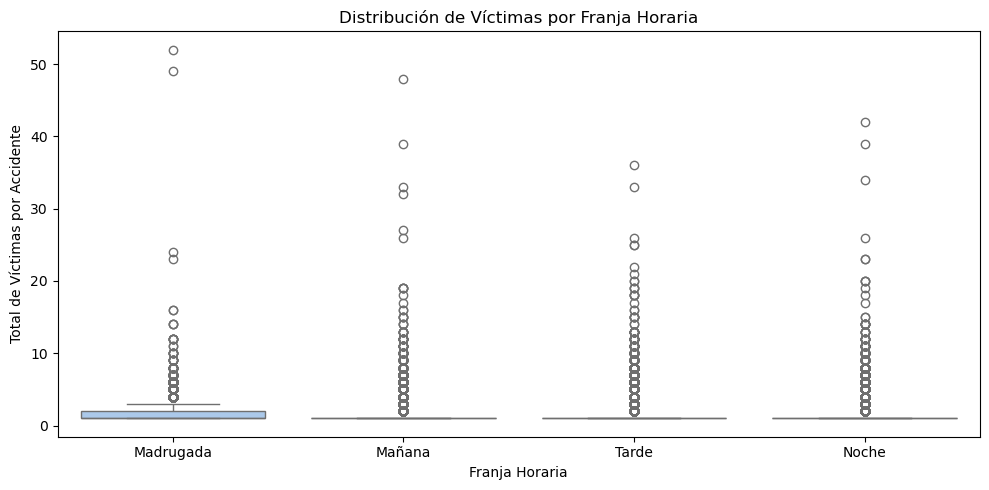

In [64]:
# 2. Distribución de víctimas totales a 30 días por franja horaria
plt.figure(figsize=(10, 5))
sns.boxplot(data=df_modelo, x='FRANJA_HORARIA', y='TOTAL_VICTIMAS_30DF', palette='pastel')
plt.title('Distribución de Víctimas por Franja Horaria')
plt.ylabel('Total de Víctimas por Accidente')
plt.xlabel('Franja Horaria')
plt.tight_layout()
plt.show()

In [65]:
# Diccionario de provincias
provincia_map = {
    1: "Araba/Álava", 2: "Albacete", 3: "Alicante/Alacant", 4: "Almería", 5: "Ávila", 6: "Badajoz",
    7: "Balears, Illes", 8: "Barcelona", 9: "Burgos", 10: "Cáceres", 11: "Cádiz", 12: "Castellón/Castelló",
    13: "Ciudad Real", 14: "Córdoba", 15: "Coruña, A", 16: "Cuenca", 17: "Girona", 18: "Granada", 19: "Guadalajara",
    20: "Gipuzkoa", 21: "Huelva", 22: "Huesca", 23: "Jaén", 24: "León", 25: "Lleida", 26: "Rioja, La", 27: "Lugo",
    28: "Madrid", 29: "Málaga", 30: "Murcia", 31: "Navarra", 32: "Ourense", 33: "Asturias", 34: "Palencia",
    35: "Palmas, Las", 36: "Pontevedra", 37: "Salamanca", 38: "Santa Cruz de Tenerife", 39: "Cantabria",
    40: "Segovia", 41: "Sevilla", 42: "Soria", 43: "Tarragona", 44: "Teruel", 45: "Toledo",
    46: "Valencia/València", 47: "Valladolid", 48: "Bizkaia", 49: "Zamora", 50: "Zaragoza", 51: "Ceuta", 52: "Melilla"
}

C:\Users\cecir\AppData\Local\Temp\ipykernel_16680\441003587.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=nombres_provincias, y=muertes_prov.values, palette='rocket')


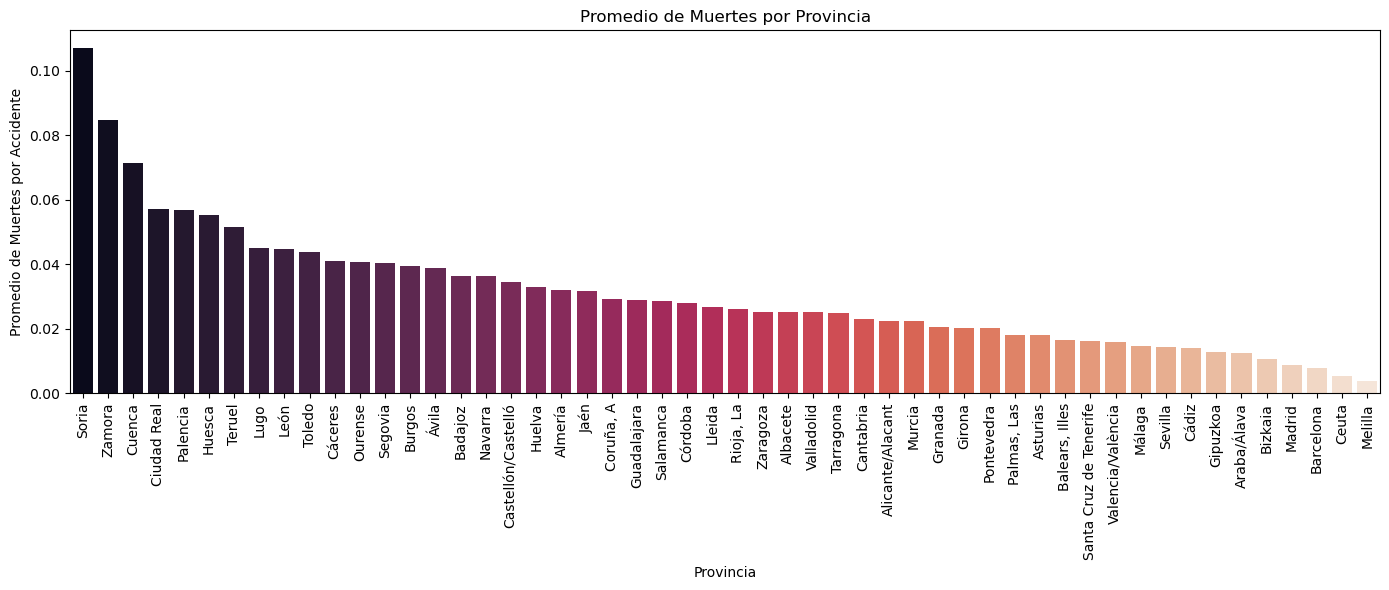

In [67]:
# 3. Muertes por provincia (promedio)
muertes_prov = df_modelo.groupby('COD_PROVINCIA')['TOTAL_MU30DF'].mean().sort_values(ascending=False)
nombres_provincias = muertes_prov.index.map(provincia_map)

plt.figure(figsize=(14, 6))
sns.barplot(x=nombres_provincias, y=muertes_prov.values, palette='rocket')
plt.title('Promedio de Muertes por Provincia')
plt.xlabel('Provincia')
plt.ylabel('Promedio de Muertes por Accidente')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# TOPSIS

In [68]:
# Agrupaciones y cálculo de promedios de criterios y totalización de accidentes

# Agrupación por provincia
provincia_grouped = df_modelo.groupby('COD_PROVINCIA', observed=True).agg(
    {**{c: 'mean' for c in criterios}, 'COD_PROVINCIA': 'count'}
).rename(columns={'COD_PROVINCIA': 'NUM_ACCIDENTES'}).reset_index()

# Agrupación por franja horaria
franja_grouped = df_modelo.groupby('FRANJA_HORARIA', observed=True).agg(
    {**{c: 'mean' for c in criterios}, 'COD_PROVINCIA': 'count'}
).rename(columns={'COD_PROVINCIA': 'NUM_ACCIDENTES'}).reset_index()

# Agrupación por Zona Agrupada
zona_grouped = df_modelo.groupby('ZONA_AGRUPADA', observed=True).agg(
    {**{c: 'mean' for c in criterios}, 'COD_PROVINCIA': 'count'}
).rename(columns={'COD_PROVINCIA': 'NUM_ACCIDENTES'}).reset_index()

# Agrupación por dia tipo
diatipo_grouped = df_modelo.groupby('DIA_TIPO', observed=True).agg(
    {**{c: 'mean' for c in criterios}, 'COD_PROVINCIA': 'count'}
).rename(columns={'COD_PROVINCIA': 'NUM_ACCIDENTES'}).reset_index()


In [69]:
# Se añade NUM_ACCIDENTES a criterios y se definen pesos

criterios = ['TOTAL_MU30DF', 'TOTAL_HG30DF', 'TOTAL_HL30DF', 'TOTAL_VEHICULOS', 'NUM_ACCIDENTES']
pesos = np.array([0.35, 0.25, 0.15, 0.1, 0.15]) 


In [70]:
# Función para calcular TOPSIS
def topsis(df_grouped, criterios, pesos):
    X = df_grouped[criterios].values
    scaler = MinMaxScaler()
    X_norm = scaler.fit_transform(X)
    X_weighted = X_norm * pesos
    ideal_best = np.max(X_weighted, axis=0)
    ideal_worst = np.min(X_weighted, axis=0)
    dist_best = np.linalg.norm(X_weighted - ideal_best, axis=1)
    dist_worst = np.linalg.norm(X_weighted - ideal_worst, axis=1)
    topsis_score = dist_worst / (dist_best + dist_worst)
    return topsis_score

In [71]:
# Aplicación de TOPSIS a cada agrupación
provincia_grouped['TOPSIS_SCORE'] = topsis(provincia_grouped, criterios, pesos)
franja_grouped['TOPSIS_SCORE'] = topsis(franja_grouped, criterios, pesos)
zona_grouped['TOPSIS_SCORE'] = topsis(zona_grouped, criterios, pesos)
diatipo_grouped['TOPSIS_SCORE'] = topsis(diatipo_grouped, criterios, pesos)


In [72]:
def normalizar_scores(df,
                      columna_score='TOPSIS_SCORE',
                      nueva_columna='MULTIPLICADOR',
                      rango=0.4):
    s = df[columna_score]
    s_min, s_max, s_mean = s.min(), s.max(), s.mean()
    # Normalizamos en torno a la media
    df[nueva_columna] = 1 + ((s - s_mean) / (s_max - s_min)) * rango
    return df

    """
    Mapea los TOPSIS_SCORE de cada fila para que:
      • El valor medio (mean) de la columna quede en 1.0
      • Los extremos (min, max) queden en [1 - rango/2, 1 + rango/2]
    """

In [73]:
# Aplicar normalización
prov_riesgo = normalizar_scores(provincia_grouped.copy(), nueva_columna='MULTIPLICADOR_RIESGO')
franja_riesgo = normalizar_scores(franja_grouped.copy(), nueva_columna='MULTIPLICADOR_RIESGO')
zona_riesgo = normalizar_scores(zona_grouped.copy(), nueva_columna='MULTIPLICADOR_RIESGO')
diatipo_riesgo = normalizar_scores(diatipo_grouped.copy(), nueva_columna='MULTIPLICADOR_RIESGO')   


In [74]:
# Paso final: guardar los DataFrames resultantes
prov_riesgo.to_csv("prov_riesgo.csv", index=False)
franja_riesgo.to_csv("franja_riesgo.csv", index=False)
zona_riesgo.to_csv("zona_riesgo.csv", index=False)
diatipo_riesgo.to_csv("diatipo_riesgo.csv", index=False)


# GENERACION DE DATASET SIMULADO PARA CALCULO DE PRIMA BASE

In [75]:
# Regenerar dataset simulado
np.random.seed(42)
n = 5000 #número de registros

# --------- Generar variables básicas ---------
edad = np.random.randint(18, 75, size=n)
experiencia = np.random.randint(0, 40, size=n)
experiencia = np.minimum(experiencia, edad - 18)  # no puede tener más experiencia que años de carnet

kilometraje = np.random.randint(0, 200000, size=n)
antiguedad_auto = np.random.randint(0, 30, size=n)
anio_fabricacion = 2025 - antiguedad_auto

siniestros = np.random.poisson(0.5, size=n)
siniestros = np.where(experiencia == 0, 0, siniestros)
siniestros = np.where(experiencia < 2, np.minimum(siniestros, 1), siniestros)

# --------- Crear Dataframe ---------
df_primabase = pd.DataFrame({
    'edad': edad,
    'experiencia': experiencia,
    'kilometraje': kilometraje,
    'antiguedad_auto': antiguedad_auto,
    'anio_fabricacion': anio_fabricacion,
    'siniestros_5y': siniestros 
})


# --------- Cálculo de prima realista (fórmula multiplicativa) ---------
prima_base = 300

df_primabase["prima_real"] = (
    prima_base
    * (1 + (df_primabase["edad"] < 25) * 0.25)
    * (1 + (df_primabase["experiencia"] < 5) * 0.20)
    * (1 - (df_primabase["experiencia"] > 20) * 0.10)
    * (1 + (df_primabase["antiguedad_auto"] > 10) * 0.15)
    * (1 + (df_primabase["kilometraje"] > 150000) * 0.10)
    * (1 + df_primabase["siniestros_5y"] * 0.20)
)

# --------- Añadir ruido (simulación realista) ---------
df_primabase["prima_real"] += np.random.normal(0, 30, size=n)

# Vista previa
df_primabase.head()

,edad,experiencia,kilometraje,antiguedad_auto,anio_fabricacion,siniestros_5y,prima_real
0,56,8,85269,29,1996,1,388.413654
1,69,36,141041,22,2003,1,343.950439
2,46,9,35969,14,2011,0,340.588663
3,32,14,163521,26,1999,0,393.579234
4,60,36,91679,24,2001,0,288.651830


# Comparación entre XGBoost Regressor y LightGBM

In [76]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import pandas as pd

# 1. Preparar los datos
X = df_primabase.drop(columns='prima_real')
y = df_primabase['prima_real']

# 2. Separar en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Definir modelos
xgb_model = XGBRegressor(n_estimators=100, max_depth=4, learning_rate=0.1, random_state=42)
lgbm_model = LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

# 4. Entrenar modelos
xgb_model.fit(X_train, y_train)
lgbm_model.fit(X_train, y_train)

# 5. Hacer predicciones
y_pred_xgb = xgb_model.predict(X_test)
y_pred_lgbm = lgbm_model.predict(X_test)

# 6. Evaluar
print("🔹 XGBoost")
print(f"MAE: {mean_absolute_error(y_test, y_pred_xgb):.2f} €")
print(f"R² : {r2_score(y_test, y_pred_xgb):.4f}")

print("\n🔹 LightGBM")
print(f"MAE: {mean_absolute_error(y_test, y_pred_lgbm):.2f} €")
print(f"R² : {r2_score(y_test, y_pred_lgbm):.4f}")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000564 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 419
[LightGBM] [Info] Number of data points in the train set: 4000, number of used features: 6
[LightGBM] [Info] Start training from score 385.781835
🔹 XGBoost
MAE: 24.83 €
R² : 0.8753

🔹 LightGBM
MAE: 25.78 €
R² : 0.8657


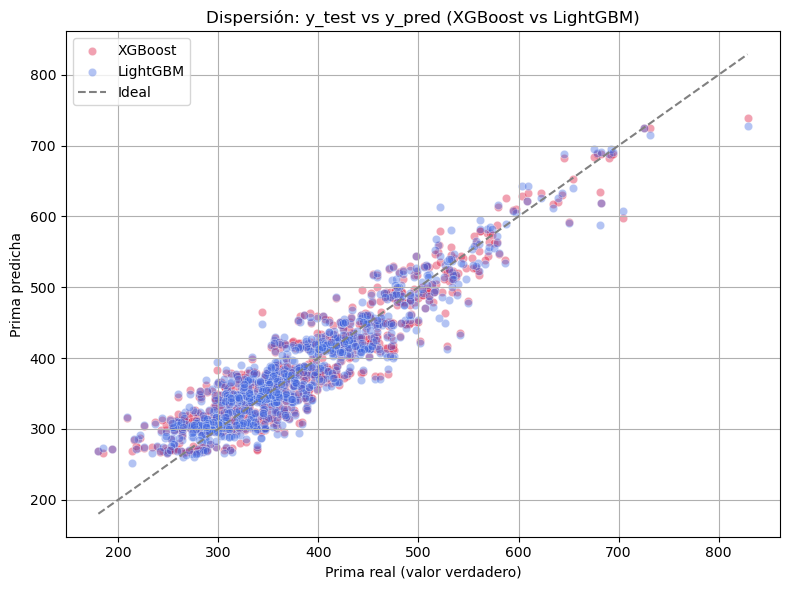

In [77]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.figure(figsize=(8, 6))

# Puntos reales vs predicción XGBoost
sns.scatterplot(x=y_test, y=y_pred_xgb, alpha=0.4, label="XGBoost", color='crimson')

# Puntos reales vs predicción LightGBM
sns.scatterplot(x=y_test, y=y_pred_lgbm, alpha=0.4, label="LightGBM", color='royalblue')

# Línea ideal de referencia
min_val = min(y_test.min(), y_pred_xgb.min(), y_pred_lgbm.min())
max_val = max(y_test.max(), y_pred_xgb.max(), y_pred_lgbm.max())
plt.plot([min_val, max_val], [min_val, max_val], color='gray', linestyle='--', label="Ideal")

plt.xlabel("Prima real (valor verdadero)")
plt.ylabel("Prima predicha")
plt.title("Dispersión: y_test vs y_pred (XGBoost vs LightGBM)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [78]:
# Crear DataFrames de importancia
importancia_xgb_df = pd.DataFrame({
    'feature': X_train.columns,
    'XGBoost': xgb_model.feature_importances_
})

importancia_lgbm_df = pd.DataFrame({
    'feature': X_train.columns,
    'LightGBM': lgbm_model.feature_importances_
})

# Unirlos
importancia_comparada = pd.merge(importancia_xgb_df, importancia_lgbm_df, on='feature')

# Normalizar LightGBM
importancia_comparada['LightGBM_norm'] = (
    importancia_comparada['LightGBM'] / importancia_comparada['LightGBM'].sum()
)

# Ordenar por XGBoost para tomar top 10
importancia_comparada = importancia_comparada.sort_values(by='XGBoost', ascending=False)
top_features = importancia_comparada.head(10).set_index('feature')




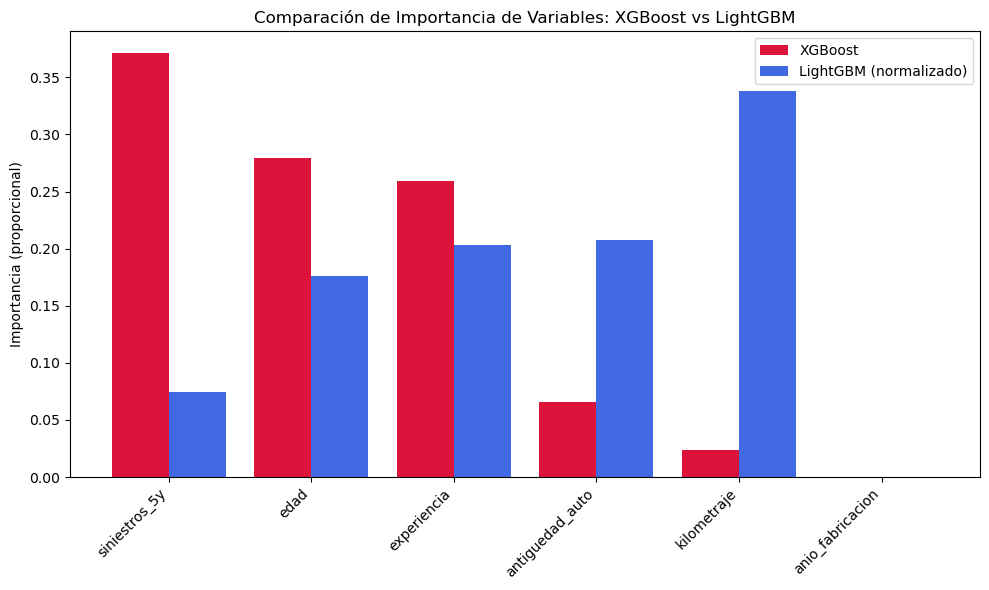

In [79]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 6))
bar_width = 0.4
x = np.arange(len(top_features))

# Barras
plt.bar(x - bar_width/2, top_features['XGBoost'], width=bar_width, label='XGBoost', color='crimson')
plt.bar(x + bar_width/2, top_features['LightGBM_norm'], width=bar_width, label='LightGBM (normalizado)', color='royalblue')

# Eje X
plt.xticks(x, top_features.index, rotation=45, ha='right')
plt.ylabel("Importancia (proporcional)")
plt.title("Comparación de Importancia de Variables: XGBoost vs LightGBM")
plt.legend()
plt.tight_layout()
plt.show()


In [80]:
import joblib
joblib.dump(xgb_model, "xgb_model.joblib")


['xgb_model.joblib']

In [81]:
df_primabase.to_csv("df_primabase.csv", index=False)
